In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import data_utils as DD

def getDummyDataset(numData, percentDisease):
  numData = numData
  numLeads = 8
  percentTrain = 1.0
  percentDisease = percentDisease
  freqs = np.tile(np.array([2.,5.,10.]), (numData, numLeads, 1))
  freqs += np.random.rand(*freqs.shape)*2. -1.

  amps = np.tile(np.array([1., 1., .5]), (numData, numLeads, 1))
  amps += np.random.rand(*amps.shape)*.5 - .25

  phases = np.tile(np.array([0.1, 0.2, -0.1]), (numData, numLeads, 1))
  phases += np.random.rand(*phases.shape)*np.pi*.5

  diseaseFlag = np.random.rand(numData) < percentDisease

  diseaseMin = 3
  diseaseMax = 7
  diseaseAmount = (np.random.rand(numData, numLeads)*(diseaseMax-diseaseMin) + diseaseMin)
  diseaseAmount[~diseaseFlag, :] = 0
  
  Dataset = DD.dummyDataDataset(freqs[:int(numData*percentTrain),...],
                                   amps[:int(numData*percentTrain),...],
                                   phases[:int(numData*percentTrain),...],
                                   diseaseFlag[:int(numData*percentTrain)],
                                   diseaseAmount[:int(numData*percentTrain),...],
                                   leads=numLeads)
  
  return Dataset

numData = 1000
trainNormalDataset = getDummyDataset(numData, 0.0)
trainAbnormalDataset = getDummyDataset(numData, 1.0)

In [9]:
import matplotlib.pyplot as plt
def visualizeLeads_comp(data, text, original_ecg):
  
  fig, axs = plt.subplots(8, figsize=(4*15, 4*8*2.5))
  fig.suptitle(f'{text}', fontsize=50, y=0.92)
  pad_size = (original_ecg.shape[-1] - data.shape[-1])//2
  if pad_size != 0:
      pad = torch.full((8, pad_size), float('nan'))
      data = torch.cat((pad, data, pad), dim=1)
  
  for lead in range(8):
        y = list(data[lead, :])
        axs[lead].plot(list(range(data.shape[-1])),y,linewidth=2, color='red')
        

        y = list(original_ecg[lead, :])
        axs[lead].plot(list(range(original_ecg.shape[-1])), y, linewidth=1, color='blue', linestyle=":")
        axs[lead].set_xlabel(f'Lead {lead}',fontsize=30)
        axs[lead].xaxis.label.set_visible(True)

        axs[lead].tick_params(axis='x', labelsize=30)  # For x-axis
        axs[lead].tick_params(axis='y', labelsize=30)  # For y-axis
      

  plt.subplots_adjust(hspace=0.4, wspace=0.2)
  return fig

torch.Size([8, 5000])


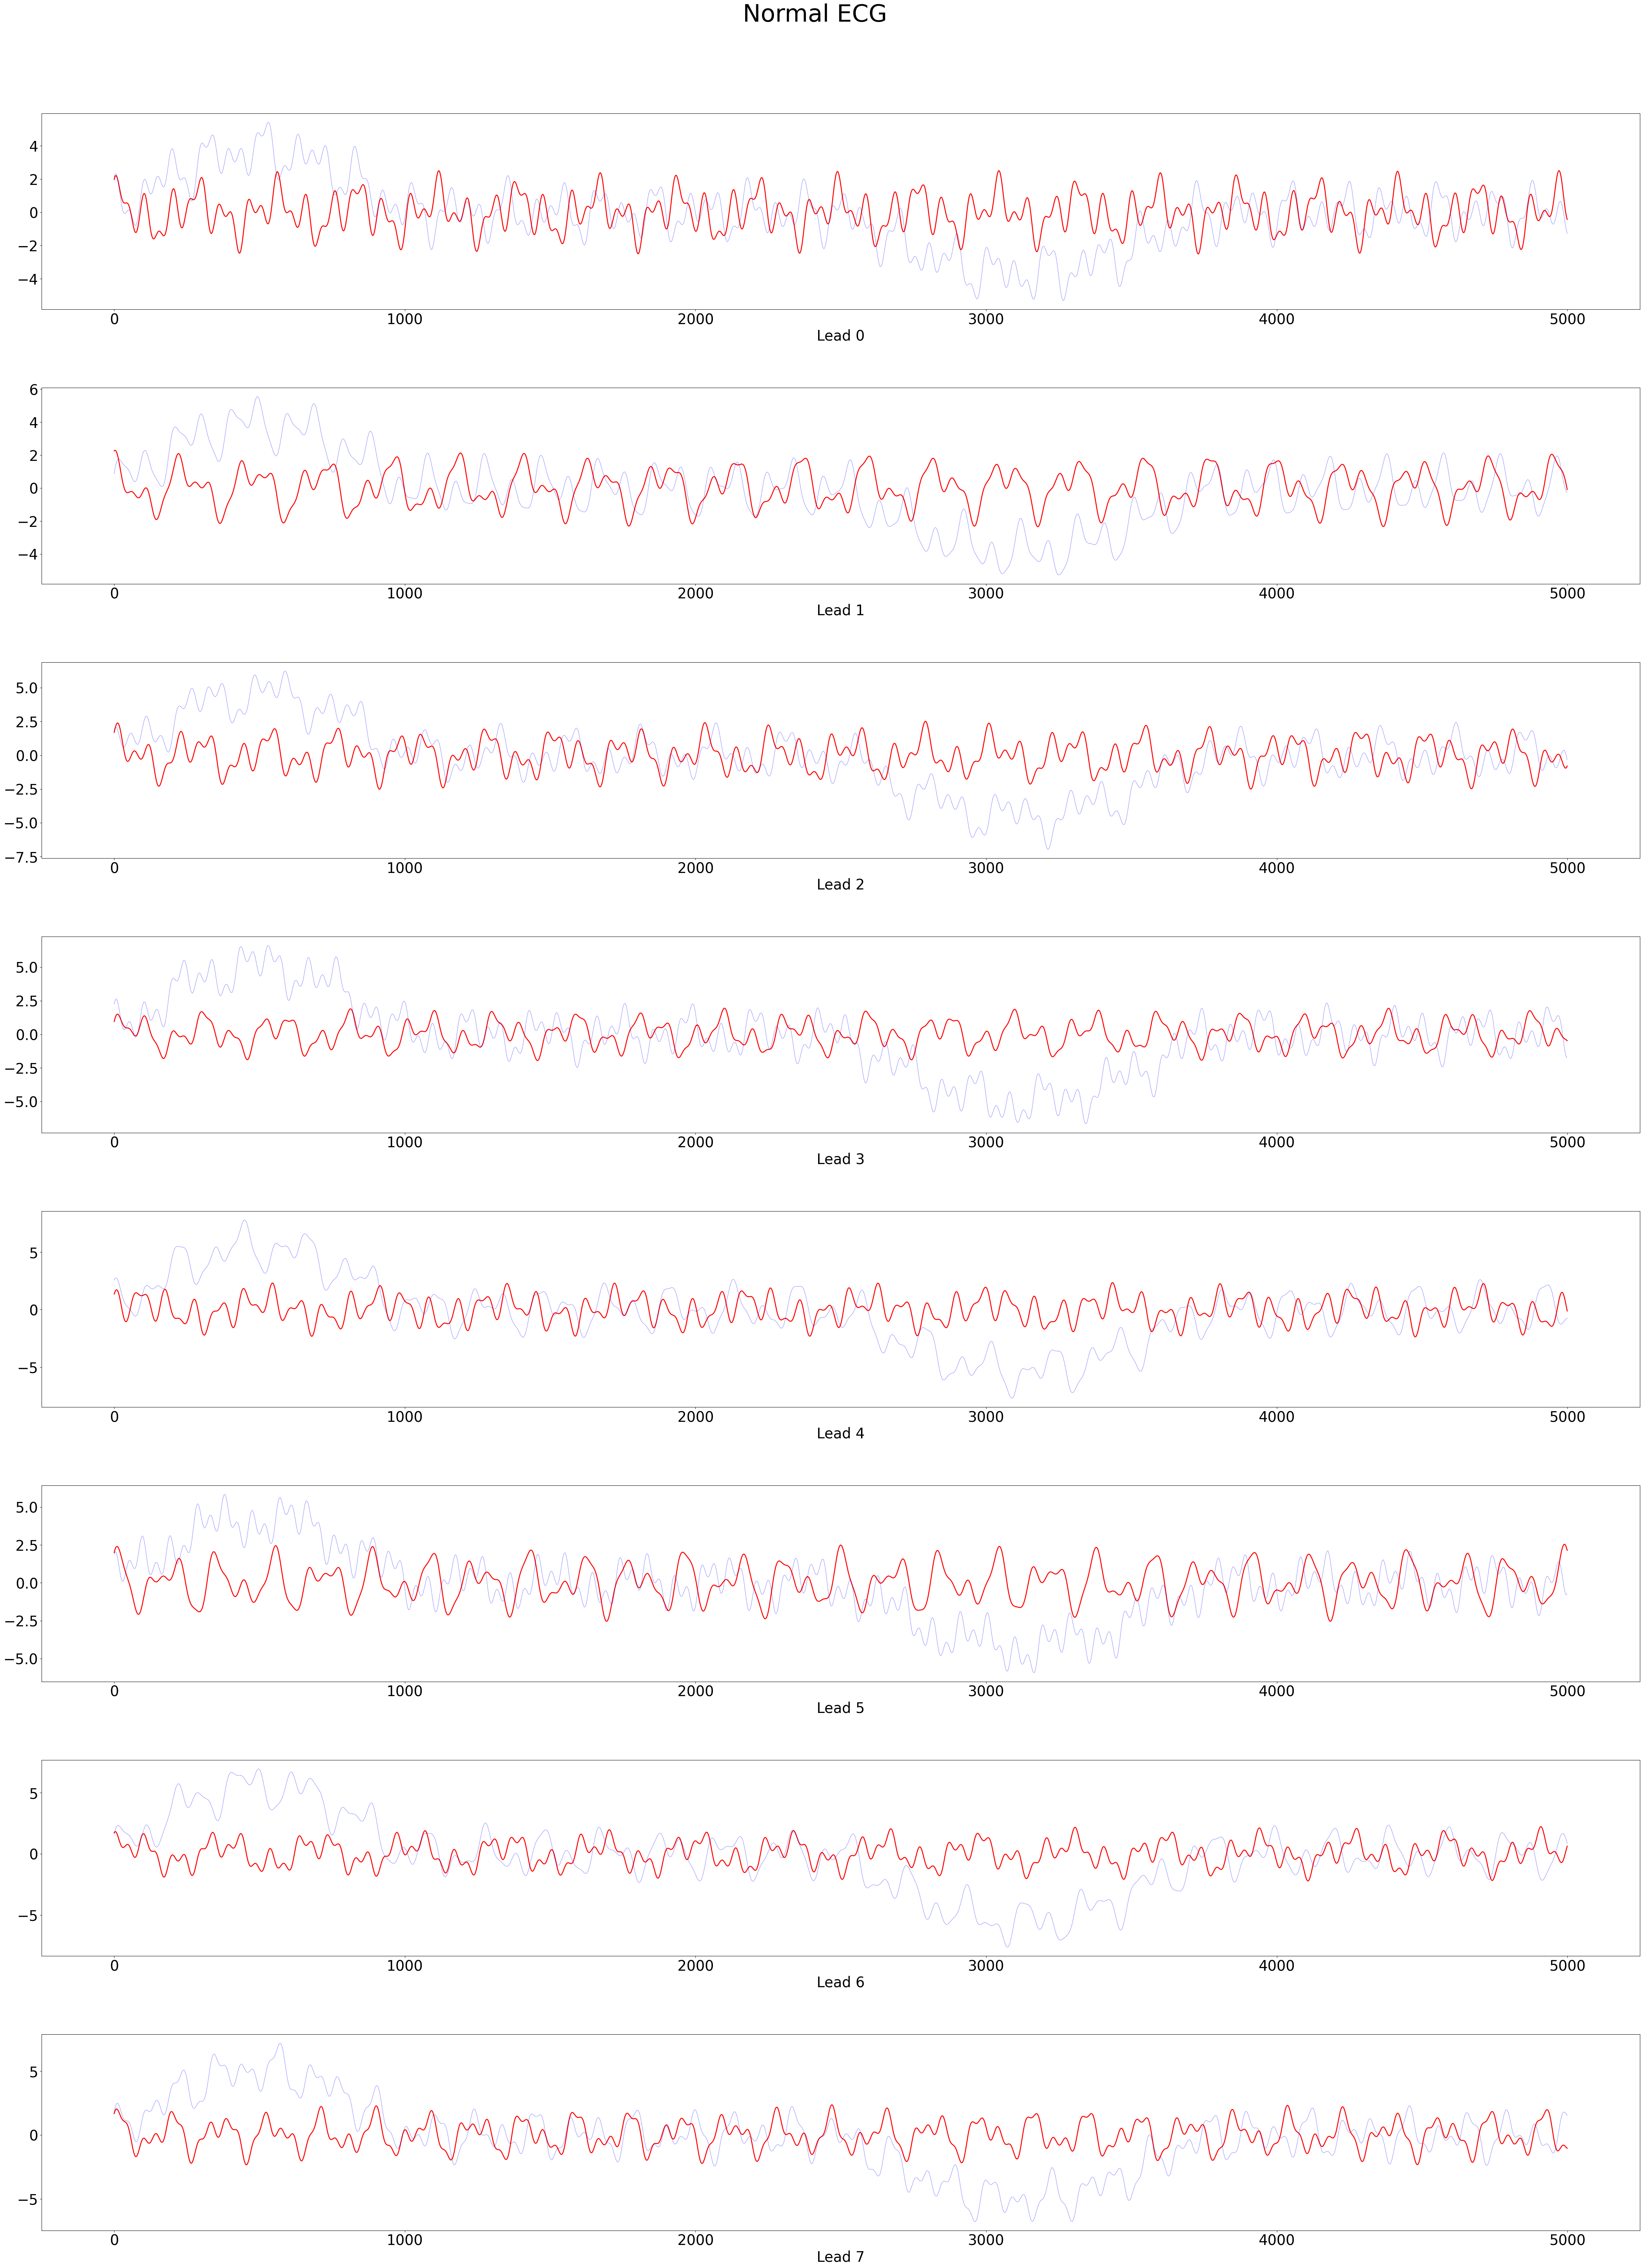

In [15]:
ecg1 = trainNormalDataset[0][0]
ecg2 = trainAbnormalDataset[0][0]
ecg1 = ecg1.squeeze(0)
ecg2 = ecg2.squeeze(0)
print(ecg1.shape)
fig = visualizeLeads_comp(ecg1, 'Normal ECG', ecg2) 

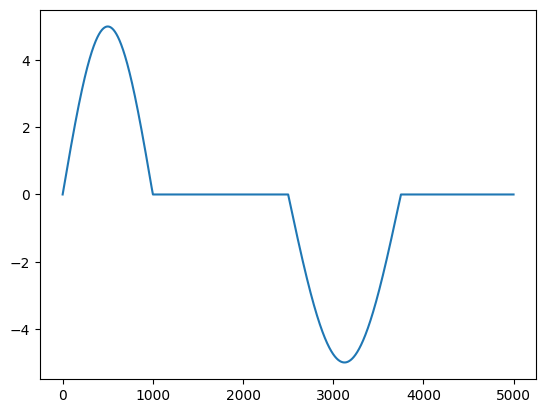

In [25]:
import numpy as np
import matplotlib.pyplot as plt
timeSteps = 5000
dt = 10/timeSteps
data = np.zeros((8, timeSteps))
diseaseAmount = [5]
timeVec = np.linspace(0, 10-dt, timeSteps)

lead = 0
diseaseSignature = np.zeros(data[lead, :].shape)
diseaseSignature[0:round(timeSteps/5)] = np.sin(timeVec[0:round(timeSteps/5)] * np.pi * 2 * (1/4)) * diseaseAmount[lead]
diseaseSignature[round(timeSteps/2):round(3*timeSteps/4)] = \
    -np.sin(timeVec[round(timeSteps/2):round(3*timeSteps/4)] * np.pi * 2 * (1/5)) * diseaseAmount[lead]

plt.plot(diseaseSignature)

In [2]:
x_inp = torch.randn(1, 1, 8, 2500).float()
from generator import Generator
generator = Generator()
generator(x_inp).shape

torch.Size([1, 1, 8, 2500])

In [6]:
from generator import conv_block, EncoderBlock, DecoderBlock
x_inp = torch.randn(1, 1, 8, 2500).float()
block1 = EncoderBlock(1, 4, (1,3), conv_stride=(1, 1))
block2 = EncoderBlock(4, 8, (1,3), conv_stride=(1, 1))
block3 = EncoderBlock(8, 16, (1,3), conv_stride=(1, 1))
block4 = EncoderBlock(16, 32, (1,3), conv_stride=(1, 1))


latent_block = conv_block(32, 64, (1,3), stride=(1, 1), padding=(0, 1))


dblock1 = DecoderBlock(in_channels=64, out_channels=32, kernel_size=(1,3), stride=(1,3))
dblock2 = DecoderBlock(32, 16, kernel_size=(1,3), stride=(1,3))
dblock3 = DecoderBlock(16, 8, kernel_size=(1,3), stride=(1,3))
dblock4 = DecoderBlock(8, 4, kernel_size=(1,3), stride=(1,3))

final_block = torch.nn.Conv2d(in_channels=5, out_channels=1, kernel_size=(1,3), padding=(0,1), stride=(1,1))

print("ENCODER STUFF")
x1, d1 = block1(x_inp)
print(x1.shape, d1.shape)
x2, d2 = block2(d1)
print(x2.shape, d1.shape)
x3, d3 = block3(d2)
print(x3.shape, d2.shape)
x4, d4 = block4(d3)
print(x4.shape, d3.shape)

print("LATENT STUFF")
print(f"input shape: {d4.shape}")
x = latent_block(d4)
print(f"output shape: {x.shape}") 

print("DECODER STUFF")
x = dblock1(x, x4)
print(x.shape)
x = dblock2(x, x3)
print(x.shape)
x = dblock3(x, x2)
print(x.shape)
x = dblock4(x, x1)
print(x.shape)

final_input = torch.cat([x, x_inp], dim=1)
final = final_block(final_input)
print(final.shape)

ENCODER STUFF
torch.Size([1, 4, 8, 2496]) torch.Size([1, 4, 8, 832])
torch.Size([1, 8, 8, 828]) torch.Size([1, 4, 8, 832])
torch.Size([1, 16, 8, 272]) torch.Size([1, 8, 8, 276])
torch.Size([1, 32, 8, 86]) torch.Size([1, 16, 8, 90])
LATENT STUFF
input shape: torch.Size([1, 32, 8, 28])
output shape: torch.Size([1, 64, 8, 28])
DECODER STUFF
upsampled to torch.Size([1, 32, 8, 84])
torch.Size([1, 32, 8, 90])
upsampled to torch.Size([1, 16, 8, 270])
torch.Size([1, 16, 8, 276])
upsampled to torch.Size([1, 8, 8, 828])
torch.Size([1, 8, 8, 832])
upsampled to torch.Size([1, 4, 8, 2496])
torch.Size([1, 4, 8, 2500])
torch.Size([1, 1, 8, 2500])


In [3]:
from generator import define_default_generator_params, generator_V1
params = define_default_generator_params()
net = generator_V1( encoderParams=  params['encoderParams'],
                    decoderParams=  params['decoderParams'],
                    latentParams=   params['latentParams'],
                    finalParams=    params['finalParams'])
data = torch.rand((10,1,8,2500))
print(net(data).shape)

=======Generator Unet V1 Startup=======
Generating encoder
   ->Generating 0 of stage 0
   ->Generating 1 of stage 0
   ->Generating 2 of stage 0
   ->Generating 0 of stage 1
   ->Generating 1 of stage 1
   ->Generating 2 of stage 1
   ->Generating 0 of stage 2
   ->Generating 1 of stage 2
   ->Generating 2 of stage 2
Generating decoder
   ->Generating 0 of stage 0
   ->Generating 1 of stage 0
   ->Generating 2 of stage 0
   ->Generating 0 of stage 1
   ->Generating 1 of stage 1
   ->Generating 2 of stage 1
   ->Generating 0 of stage 2
   ->Generating 1 of stage 2
   ->Generating 2 of stage 2
Generating latent
Generating final
=======Startup Done=======
generator_V1(
  (encoderStages): Sequential(
    (0): Sequential(
      (0): coderBlock(
         standard covolution
        (layers): Sequential(
          (0): Conv2d(1, 8, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
          (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Re

In [173]:
class dummyDataset(Dataset):
    def __init__(self, freqArray, ampArray, phaseArray, diseaseFlagArray, diseaseAmountArray, leads=8, timeSteps=5000):
        self.freqs = freqArray.tolist()
        self.amps = ampArray.tolist()
        self.phases = phaseArray.tolist()
        self.diseaseFlags = diseaseFlagArray.tolist()
        self.diseaseAmount = diseaseAmountArray.tolist()
        self.leads = leads
        self.timeSteps = timeSteps
        
    def __getitem__(self, item):
        data = self.generateSample(freqs=self.freqs[item],
                                   amps=self.amps[item],
                                   phases=self.phases[item],
                                   diseaseFlag=self.diseaseFlags[item],
                                   diseaseAmount=self.diseaseAmount[item])
        return tch.tensor(data).unsqueeze(0).float(),  tch.tensor(self.diseaseFlags[item]).float()
    
    def __len__(self):
        return len(self.diseaseFlags)
    
    def generateSample(self, freqs, amps, phases, diseaseFlag, diseaseAmount):
        dt = 10/self.timeSteps
        timeVec = np.linspace(0, 10-dt, self.timeSteps)
        data = np.tile((np.zeros(timeVec.shape)), (self.leads, 1))
        
        for lead in range(self.leads):
            for fr,am,ph in zip(freqs[lead], amps[lead], phases[lead]):
                data[lead, :] += np.sin(timeVec * np.pi * 2 * fr + ph) * am
            if diseaseFlag:
                diseaseSignature = np.zeros(data[lead, :].shape)
                diseaseSignature[0:round(self.timeSteps/5)] = np.sin(timeVec[0:round(self.timeSteps/5)] * np.pi * 2 * (1/4)) * diseaseAmount[lead]
                diseaseSignature[round(self.timeSteps/2):round(3*self.timeSteps/4)] = \
                    -np.sin(timeVec[round(self.timeSteps/2):round(3*self.timeSteps/4)] * np.pi * 2 * (1/5)) * diseaseAmount[lead]
                data[lead, :] += diseaseSignature
                
                
        return data

In [176]:
numData = 3
numLeads = 8
percentTrain = 0.9
percentDisease = 0.5

freqs = np.tile(np.array([2., 5., 10.]), (numData, numLeads, 1))
freqs += np.random.rand(*freqs.shape)*2. -1.

amps = np.tile(np.array([1.,1.,.5]), (numData, numLeads, 1))
amps += np.random.rand(*amps.shape)*.5 - .25

phases = np.tile(np.array([0.1, 0.2, -0.1]), (numData, numLeads, 1))
phases += np.random.rand(*phases.shape)*np.pi*.5

diseaseFlag = np.random.rand(numData) > percentDisease

diseaseMin = 3
diseaseMax = 7
diseaseAmount = (np.random.rand(numData, numLeads) * (diseaseMax - diseaseMin) + diseaseMin)
diseaseAmount[~diseaseFlag, :] = 0

trainDataset = dummyDataset(freqs[:int(numData*percentTrain),...],
								  amps[:int(numData*percentTrain),...],
								  phases[:int(numData*percentTrain),...],
								  diseaseFlag[:int(numData*percentTrain)],
								  diseaseAmount[:int(numData*percentTrain),...],
								  leads=numLeads)

label=tensor(1.)


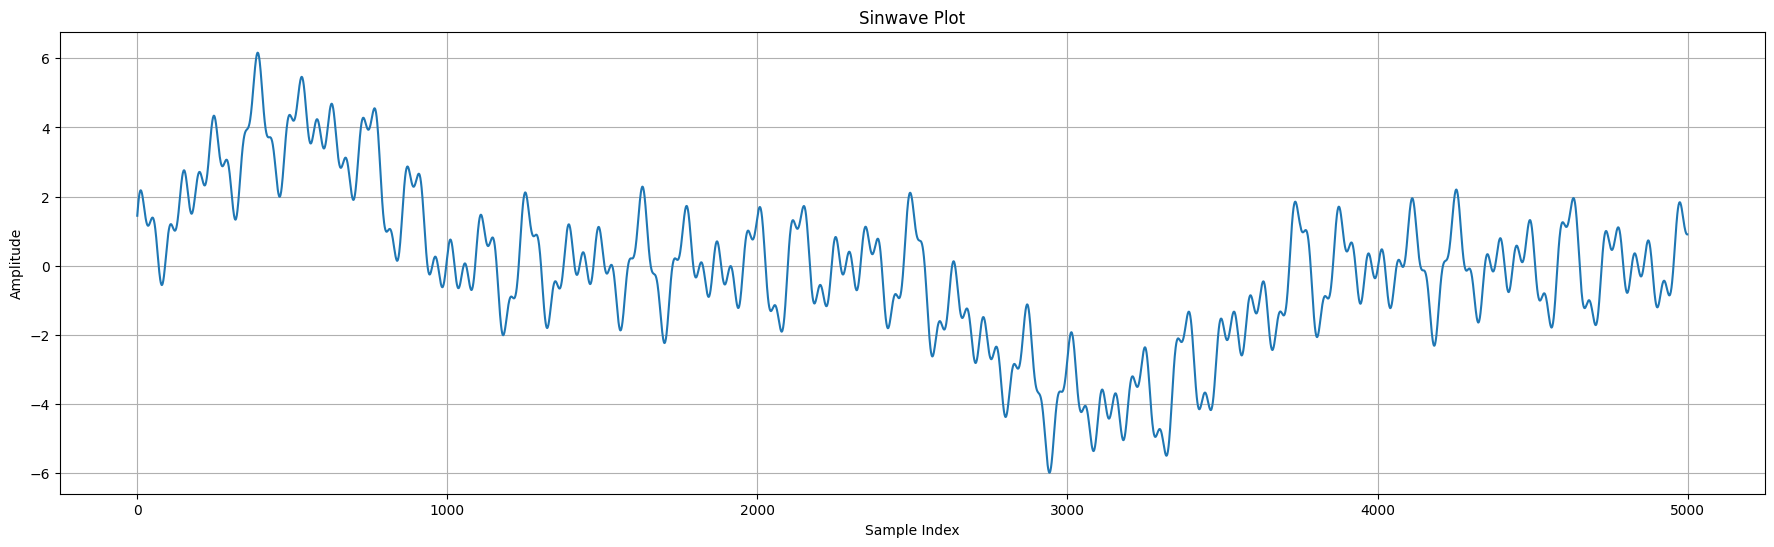

In [177]:
fullwave, label = trainDataset[0]
sinwave = fullwave[0, 0]

print(f"{label=}")
plt.figure(figsize=(22, 6))
# Plotting the sinwave
plt.plot(sinwave)

plt.title('Sinwave Plot')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


In [15]:
import network_params as netParams
import discriminator as ECGclass

firstLayerParams = dict(in_channels=1,out_channels=32,bias=True,kernel_size=(1,7),maxPoolKernel=7)
lastLayerParams = dict(maxPoolSize=(8,1))
discriminatorParams =  {'temporalResidualBlockParams':netParams.spatioTemporalParams_v4['temporalResidualBlockParams'],
				  'spatialResidualBlockParams':netParams.spatioTemporalParams_v4['spatialResidualBlockParams'],
				  'integrationMethod':'concat','problemType':'BCELogits','firstLayerParams':firstLayerParams,'lastLayerParams':lastLayerParams}

discriminator = ECGclass.ECG_SpatioTemporalNet(**discriminatorParams)
discriminator(torch.rand((10,1,8,2500)))

tensor([[0.3701],
        [0.3979],
        [0.3399],
        [0.3874],
        [0.3738],
        [0.3881],
        [0.3279],
        [0.4014],
        [0.3381],
        [0.3709]], grad_fn=<AddmmBackward0>)

In [ ]:
def trainExplainabilityNetworks_v3(discriminator, generator, optim_discriminator, optim_generator, modificationFunction, modificationPenalty, trainData, testData, epochs, lossParams, modelSaveDir, label, genIter_perEp, discrimIter_perEp, classificationIter_perEp, evalUpdates, lossFun, logtowandb):
    prevTrainingLoss_wgan = 0.0
    prevTrainingLoss_generator = 0.0
    prevTrainingLoss_class = 0.0
    bestEval = 1e10
    
    problemType = discriminator.problemType
    for ep in range(epochs):
        print(f"Begin epoch {ep}")
        discriminator.train()
        generator.train()
        runningLoss_class = 0.0
        runningLoss_wgan = 0.0
        runningLoss_generator = 0.0
        running_fake = 0.0
        running_true = 0.0
        running_genPen = 0.0
        ix = 1
        for trueData, flag in trainData:
            print(f"Begin iteration {ix} of {len(trainData)}")
            ix+=1
            trueData = trueData.to(device)
            flag = flag.to(device)
            
            for classIx in range(classificationIter_perEp[ep]):
                print(f'classification step {classIx+1} of {classificationIter_perEp[ep]}', end='\r')
                optim_discriminator.zero_grad()
                call = discriminator(trueData)

In [13]:
import torch as tch
import torch.nn as nn
import warnings
class ECGNetworkWarning(UserWarning):
    pass


class coderBlock(nn.Module):
    def __init__(self,in_channels, out_channels, conv_kernel=(3,3,3),\
                 conv_stride=1, conv_pad=0,conv_dilation=1,conv_bias=True,\
                 do_max = True,max_kernel_size=(3,3,3),max_stride=1,max_pad=0,max_dilation=1,\
                 drop_prob=0.5,convType='standard',
                 do_drop=True,
                 actFun='relu',
                 do_batch_norm=True):
        super(coderBlock,self).__init__()
        layers = []
        self.convType = convType
        if convType == 'standard':
            layers.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                               kernel_size=conv_kernel, stride=conv_stride, padding=conv_pad,
                                               dilation=conv_dilation, bias=conv_bias, padding_mode='zeros'))
        elif convType == 'transpose':
            layers.append(nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels,
                                               kernel_size=conv_kernel, stride=conv_stride, padding=conv_pad,
                                               dilation=conv_dilation, bias=conv_bias, padding_mode='zeros'))
        elif convType == 'none':
            pass
        else:
            warnings.warn('Invalid block type, skipping convolution layer',ECGNetworkWarning)
    
        if do_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        if actFun == 'relu':
            layers.append(nn.ReLU())
        
        if do_max:
            layers.append(nn.MaxPool2d(kernel_size=max_kernel_size, stride=max_stride, padding=max_pad, dilation=max_dilation))
        if do_drop:
            layers.append(nn.Dropout(drop_prob))

        if len(layers) == 0:
            warnings.warn('No layers defined',SegmentationNetworkWarning)
        self.layers = nn.Sequential(*layers)

    def extra_repr(self):
        return f' {self.convType} covolution'

    def forward(self, x):
        return self.layers(x)



def define_default_generator_params():
    return dict(encoderParams=dict( convType=[['standard','standard','none']]*3,
                                    numStages=3,
                                    stagesPerLayer=[3,3,3],
                                    inCh=[[1,8,-1],[16,32,-1],[64,64,-1]],
                                    outCh=[[8,16,-1],[32,64,-1],[64,128,-1]],
                                    convKernel=[[(1,3),(1,3),(1,3)]]*3,
                                    conv_stride = [[1,1,0]]*3,
                                    conv_dilation = [[1,1,0]]*3,
                                    bias=[[True,True,False]]*3,
                                    convPad=[[(0,1),(0,1),(0,1)]]*3,
                                    dropProb=[[0.5, 0.5, 0.5]]*3,
                                    drop = [[True,True,False]]*3,
                                    batchNorm=[[True, True, False]]*3,
                                    actFun=[['relu','relu','none']]*3,
                                    maxPool=[[False,False,True]]*3,
                                    max_kernel_size=[[(),(),(1,3)]]*3,
                                    max_stride=[[(),(),(1,3)]]*3,
                                    max_padding=[[0,0,0]]*3,
                                    max_dilation=[[0,0,1]]*3,
                                    ),
                decoderParams=dict( convType=[['transpose','standard','standard']]*3,
                                    numStages=3,
                                    stagesPerLayer=[3,3,3],
                                    inCh=[[256,128,64],[128,64,32],[48,32,16]],
                                    outCh=[[128,64,64],[64,32,32],[32,16,16]],
                                    convKernel=[[(1,3),(1,3),(1,3)]]*3,
                                    conv_stride = [[(1,3),1,1]]*3,
                                    conv_dilation = [[1,1,1]]*3,
                                    bias=[[True,True,True]]*3,
                                    convPad=[[(0,0),(0,1),(0,2)]]*3,
                                    dropProb=[[0.5,0.5,0.5]]*3,
                                    drop = [[True,True,True]]*3,
                                    batchNorm=[[True,True,True]]*3,
                                    actFun=[['relu','relu','relu']]*3,
                                    maxPool=[[False,False,False]]*3,
                                    max_kernel_size=[[(),(),()]]*3,
                                    max_stride=[[0,0,3]]*3,
                                    max_padding=[[0,0,0]]*3,
                                    max_dilation=[[0,0,1]]*3, 
                                    ),
                latentParams= dict( inCh = 128,
                                    outCh = 128,
                                    convKernel = (1,3),
                                    conv_stride = 1,
                                    conv_dilation = 1,
                                    bias = True,
                                    convPad = (0,1),
                                    dropProb=0.5,
                                    drop = True,
                                    batchNorm=True,
                                    actFun='relu',
                                    maxPool=False,
                                    max_kernel_size=(),
                                    max_stride=[],
                                    max_padding=[],
                                    max_dilation=[]),
                finalParams = dict( inCh = 17,
                                    outCh = 1,
                                    convKernel = (1,3),
                                    conv_stride = 1,
                                    conv_dilation = 1,
                                    bias = True,
                                    convPad = (0,1),
                                    dropProb=0.5,
                                    drop = False,
                                    batchNorm=False,
                                    actFun='none',
                                    maxPool=False,
                                    max_kernel_size=(),
                                    max_stride=[],
                                    max_padding=[],
                                    max_dilation=[]))


class generator_V1(nn.Module):
    def __init__(self,encoderParams,decoderParams,latentParams,finalParams,verbose=True):
        super(generator_V1, self).__init__()
        self.verbose = verbose
        self._log("=======Generator Unet V1 Startup=======")
        self._generateBlock(encoderParams,blockType='encoder')
        self._generateBlock(decoderParams,blockType='decoder')
        self._generateBlock(latentParams,blockType='latent')
        self._generateBlock(finalParams,blockType='final')
        self._log("=======Startup Done=======")
        # self._log(self)
        

    def _log(self,msg):
        if self.verbose:
            print(msg)
        
    def _generateBlock(self,params,blockType):
        self._log(f'Generating {blockType}')
        if blockType == 'final' or blockType == 'latent':
            block = coderBlock( in_channels =   params['inCh'], 
                                out_channels =  params['outCh'],
                                conv_kernel=    params['convKernel'],
                                conv_stride=    params['conv_stride'],
                                conv_pad=       params['convPad'],
                                conv_dilation=  params['conv_dilation'],
                                conv_bias=      params['bias'],
                                do_max =        params['maxPool'],
                                max_kernel_size=params['max_kernel_size'],
                                max_stride=     params['max_stride'],
                                max_pad=        params['max_padding'],
                                max_dilation=   params['max_dilation'],
                                drop_prob=      params['dropProb'],
                                convType=       'standard',
                                do_drop=        params['drop'],
                                actFun=         params['actFun'],
                                do_batch_norm=  params['batchNorm'])
            setattr(self,f'{blockType}Block',block)
            return
        stages = []
        for stage in range(params['numStages']):
            blocks = []
            for b in range(params['stagesPerLayer'][stage]):
                self._log(f'   ->Generating {b} of stage {stage}')
                block = coderBlock( in_channels =   params['inCh'][stage][b], 
                                    out_channels =  params['outCh'][stage][b],
                                    conv_kernel=    params['convKernel'][stage][b],
                                    conv_stride=    params['conv_stride'][stage][b],
                                    conv_pad=       params['convPad'][stage][b],
                                    conv_dilation=  params['conv_dilation'][stage][b],
                                    conv_bias=      params['bias'][stage][b],
                                    do_max =        params['maxPool'][stage][b],
                                    max_kernel_size=params['max_kernel_size'][stage][b],
                                    max_stride=     params['max_stride'][stage][b],
                                    max_pad=        params['max_padding'][stage][b],
                                    max_dilation=   params['max_dilation'][stage][b],
                                    drop_prob=      params['dropProb'][stage][b],
                                    convType=       params['convType'][stage][b],
                                    do_drop=        params['drop'][stage][b],
                                    actFun=         params['actFun'][stage][b],
                                    do_batch_norm=  params['batchNorm'][stage][b])
                blocks.append(block)
            stages.append(nn.Sequential(*blocks))
        setattr(self,f'{blockType}Stages',nn.Sequential(*stages))  

    def encode(self,X):
        encoderOutputs = []
        self._log('Encoding')
        for encoderBlock in self.encoderStages:
            self._log(f'   ->{X.shape}')
            X = encoderBlock(X)
            encoderOutputs.append(X)
        return X, encoderOutputs

    def decode(self,X,encoderOutputs):
        self._log('Decoding')
        for decodeIx in range(len(self.encoderStages)):
            
            features = self.attachFeatures(X,encoderOutputs[-(decodeIx+1)])
            self._log(f'   ->in features: {features.shape}')
            X = self.decoderStages[decodeIx](features)
            self._log(f'   ->out features: {X.shape}')
        return X

    def attachFeatures(self,f1,f2):
        ##truncates m and/or n as needed to attach.
        self._log(f'        ->Attaching {[val for val in f1.shape]} to {[val for val in f2.shape]}')
        if f1.shape == f2.shape:
            return tch.cat((f1,f2),dim=1)

        minDims =  tch.min(tch.tensor([list(f1.shape),list(f2.shape)]),dim=0)[0]
        if len(minDims) == 4:#batch, channel, m, n
            return tch.cat((f1[:,:,:minDims[2],:minDims[3]],
                            f2[:,:,:minDims[2],:minDims[3]]),dim=1)
        if len(minDims) == 3:#channel, m, n
            return tch.cat((f1[:,:minDims[1],:minDims[2]],
                            f2[:,:minDims[1],:minDims[2]]),dim=1)

    def forward(self,InputX):
        X, encoderOutputs = self.encode(InputX)
        print(f'Latent input shape: {X.shape}')
        X = self.latentBlock(X)
        print(f'Latent output shape: {X.shape}')
        X = self.decode(X, encoderOutputs)
        X = self.attachFeatures(X,InputX)
        X = self.finalBlock(X)
        return X


In [14]:
params = define_default_generator_params()
net = generator_V1( encoderParams=  params['encoderParams'],
                    decoderParams=  params['decoderParams'],
                    latentParams=   params['latentParams'],
                    finalParams=    params['finalParams'])
data = tch.rand((10,1,8,2500))

=======Generator Unet V1 Startup=======
Generating encoder
   ->Generating 0 of stage 0
   ->Generating 1 of stage 0
   ->Generating 2 of stage 0
   ->Generating 0 of stage 1
   ->Generating 1 of stage 1
   ->Generating 2 of stage 1
   ->Generating 0 of stage 2
   ->Generating 1 of stage 2
   ->Generating 2 of stage 2
Generating decoder
   ->Generating 0 of stage 0
   ->Generating 1 of stage 0
   ->Generating 2 of stage 0
   ->Generating 0 of stage 1
   ->Generating 1 of stage 1
   ->Generating 2 of stage 1
   ->Generating 0 of stage 2
   ->Generating 1 of stage 2
   ->Generating 2 of stage 2
Generating latent
Generating final
=======Startup Done=======


In [15]:
print(net(data).shape)

Encoding
   ->torch.Size([10, 1, 8, 2500])
   ->torch.Size([10, 16, 8, 833])
   ->torch.Size([10, 64, 8, 277])
Latent input shape: torch.Size([10, 128, 8, 92])
Latent output shape: torch.Size([10, 128, 8, 92])
Decoding
        ->Attaching [10, 128, 8, 92] to [10, 128, 8, 92]
   ->in features: torch.Size([10, 256, 8, 92])
   ->out features: torch.Size([10, 64, 8, 278])
        ->Attaching [10, 64, 8, 278] to [10, 64, 8, 277]
   ->in features: torch.Size([10, 128, 8, 277])
   ->out features: torch.Size([10, 32, 8, 833])
        ->Attaching [10, 32, 8, 833] to [10, 16, 8, 833]
   ->in features: torch.Size([10, 48, 8, 833])
   ->out features: torch.Size([10, 16, 8, 2501])
        ->Attaching [10, 16, 8, 2501] to [10, 1, 8, 2500]
torch.Size([10, 1, 8, 2500])
